In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [2]:
df=pd.read_csv('../input/emotions-in-text/Emotion_final.csv')
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
df['Emotion'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [4]:
df=df.dropna()

In [5]:
X=df.drop('Emotion',axis=1)
y=df['Emotion']

In [6]:
### Vocabulary size
voc_size=10000

In [7]:
messages=X.copy()
messages.reset_index(inplace=True)

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [10]:
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

In [11]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [12]:
#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))
print(l)

35


In [13]:
sent_length=35
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 3467 3968 8561]
 [   0    0    0 ...   99  257 3303]
 [   0    0    0 ... 3968 7893 1537]
 ...
 [   0    0    0 ... 8127 7954  572]
 [   0    0    0 ...  377  572 9758]
 [   0    0    0 ...    0  572 7869]]


In [14]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3467,
       3968, 8561], dtype=int32)

In [15]:
# Creating model
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           1000000   
_________________________________________________________________
dropout (Dropout)            (None, 35, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

In [16]:
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs)
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[4 4 0 ... 1 1 1]


In [17]:
X_final.shape,y_final.shape

((21459, 35), (21459,))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=21)

In [19]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,batch_size=256,callbacks = [model_save])

Epoch 1/10
61/61 [==============================] - 7s 40ms/step - loss: 4.2209 - accuracy: 0.3521 - val_loss: 1.3459 - val_accuracy: 0.6139

Epoch 00001: val_loss improved from inf to 1.34588, saving model to weights.h5
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 1.1585 - accuracy: 0.6985 - val_loss: 0.9235 - val_accuracy: 0.7863

Epoch 00002: val_loss improved from 1.34588 to 0.92353, saving model to weights.h5
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 0.7862 - accuracy: 0.8397 - val_loss: 0.8159 - val_accuracy: 0.8154

Epoch 00003: val_loss improved from 0.92353 to 0.81586, saving model to weights.h5
Epoch 4/10
61/61 [==============================] - 1s 21ms/step - loss: 0.6610 - accuracy: 0.8773 - val_loss: 0.8469 - val_accuracy: 0.8218

Epoch 00004: val_loss did not improve from 0.81586
Epoch 5/10
61/61 [==============================] - 1s 17ms/step - loss: 0.6009 - accuracy: 0.8955 - val_loss: 0.8092 - val_accuracy: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


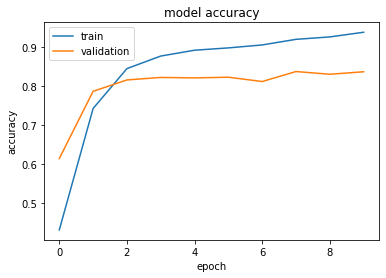

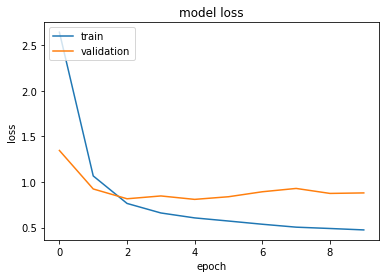

In [20]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
model.load_weights('weights.h5')

In [22]:
y_pred=model.predict_classes(X_test)
print(y_pred)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[2 0 1 ... 0 0 2]


In [23]:
print(accuracy_score(y_test,y_pred))

0.8427306616961789


In [24]:
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.84102   0.85737   0.84912       617
           1    0.72457   0.87194   0.79145       531
           2    0.85881   0.90731   0.88239      1381
           3    0.79478   0.66981   0.72696       318
           4    0.89360   0.90760   0.90054      1277
           5    0.00000   0.00000   0.00000       168

    accuracy                        0.84273      4292
   macro avg    0.68546   0.70234   0.69175      4292
weighted avg    0.81163   0.84273   0.82570      4292



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


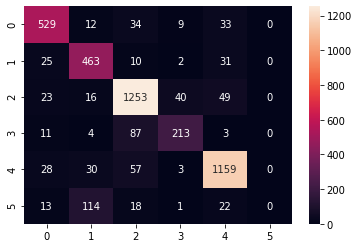

In [25]:
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

In [26]:
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [27]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    return label_encoder.classes_[np.argmax(predicti)]

In [28]:
predict_emotion('I am very happy and joyful today')

'happy'

In [29]:
predict_emotion('He is an arrogant and rude person')

'anger'

In [30]:
predict_emotion('The teacher is intimidating and scary')

'fear'